In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    sine_timeseries,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import *
from darts.models.forecasting.neural_prophet_model import (
    NeuralProphet as NeuralProphetDarts,
)
from neuralprophet import NeuralProphet
import neuralprophet

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

## Univariate example

In [ ]:
series_air = AirPassengersDataset().load()

In [ ]:
series_air.plot(label="air")
plt.legend()

In [ ]:
train_air, test_air = series_air[:-36], series_air[-36:]

Only trend and seasonality - equivalent to using Prophet

In [ ]:
model = NeuralProphetDarts()
model.fit(train_air)
preds_simple = model.predict(36)

With auto-regression

In [ ]:
model = NeuralProphetDarts(n_lags=36, n_forecasts=36, n_changepoints=20)
model.fit(train_air)
preds_ar = model.predict(36)

In [ ]:
train_air.plot(label="train")
test_air.plot(label="test")
preds_simple.plot(label="trend & season")
preds_ar.plot(label="auto-regression")

## Multivariate

In [ ]:
complete_ts = AustralianTourismDataset().load()
ts = complete_ts[["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT"]]
ts.plot()

In [ ]:
# model supports only datetime indexing
ts = TimeSeries.from_times_and_values(
    pd.date_range(start="2000-01-01", periods=len(ts), freq="D"), ts.values()
)
train, test = ts[:-4], ts[-4:]
model = NeuralProphetDarts(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=len(test),
    n_forecasts=len(test),
)

model.fit(train)
preds = model.predict(len(test))

preds.plot()
test.plot()
train.plot()

## Past covariates

In [ ]:
ice_heater = IceCreamHeaterDataset().load()

In [ ]:
train, test = ice_heater.split_after(split_point=0.8)

year = datetime_attribute_timeseries(train, attribute="year")
month = datetime_attribute_timeseries(train, attribute="month")
ice_covariates = month.stack(year)

scaler_dt_air = Scaler()
ice_covariates = scaler_dt_air.fit_transform(ice_covariates)

ice_covariates.plot()

In [ ]:
model = NeuralProphetDarts(n_lags=len(test), n_forecasts=len(test))
model.fit(train, ice_covariates)
preds_cov = model.predict(len(test))

preds_cov.plot()
train.plot()

In [ ]:
model = NeuralProphetDarts(n_lags=len(test), n_forecasts=len(test))
model.fit(train)
preds_no_cov = model.predict(len(test))

preds_no_cov.plot()
train.plot()

In [ ]:
print(mape(test, preds_cov))
print(mape(test, preds_no_cov))
# no improvement in this case but it shows that fitting and training works for multivariate time series and multivariate past covariates

In [ ]:
ice_heater = IceCreamHeaterDataset().load()
ice_train, ice_test = ice_heater["ice cream"].split_after(0.8)
heater_cov, _ = ice_heater["heater"].split_after(0.8)
horizon = len(ice_test)

model = NeuralProphetDarts(n_lags=horizon, n_forecasts=horizon)
model.fit(ice_train, heater_cov)
preds_cov = model.predict(horizon)

model = NeuralProphetDarts(n_lags=horizon, n_forecasts=horizon)
model.fit(ice_train)
preds_no_cov = model.predict(horizon)

print("MAPE with lagged regressor: ", mape(ice_test, preds_cov))
print("MAPE without lagged regressor: ", mape(ice_test, preds_no_cov))

# for some reason results vary a lot here for model with lagged regressors

ice_train.plot(label="train")
preds_cov.plot(label="cov")
preds_no_cov.plot(label="no cov")

## Future Regressors

Following the example from their website

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.139% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 627


  0%|          | 0/106 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.36E-03, min: 1.22E-01


  0%|          | 0/106 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.36E-03, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.06E-02
Epoch[627/627]: 100%|██████████| 627/627 [00:04<00:00, 137.84it/s, SmoothL1Loss=0.0015, MAE=1.45, RMSE=2.07, Loss=0.0012, RegLoss=0]  
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.139% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (py.warnings._showwarnmsg) - /Users/blazejnowicki/miniconda3/envs/prophet/lib/python3.9/site-packages/neuralprophet/

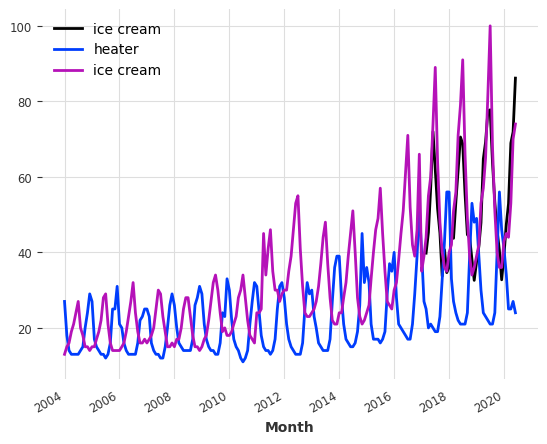

In [2]:
ice_heater = IceCreamHeaterDataset().load()
ice_train, ice_test = ice_heater["ice cream"].split_after(0.8)
heater_past, heater_future = ice_heater["heater"].split_after(0.8)
horizon = len(ice_test)

model = NeuralProphetDarts(n_lags=horizon, n_forecasts=horizon)
model.fit(ice_train, future_covariates=heater_past)

preds = model.predict(horizon, future_covariates=heater_future)
preds.plot()
ice_heater.plot()